# Introduction

![](https://raw.githubusercontent.com/Fournierp/OCR/master/CAPTCHA/samples/2b827.png)

This notebook is an attempt at solving a CAPTCHA test. This CAPTCHA is an 5 letter with noise (a blur and line that crosses the word). I attempted to process the CAPTCHAs with OpenCV by deblurring, thresholding etc to segment the words. Yet the results remained unconclusive due to the line crossing the entire word, forcing me to hardcode the coordinates of the letter to extract. 

This bruteforce method was inaccurate so I explored Deep Learning methods to get a reliable letter prediciton. The model I developped is a Convolutional Neural Network which is efficient at classifying images. Yet the challenge of the data is that we have a single sample per label and could have in testing, some unseen labels (due to the huge number of CAPTCHA combiations: 36^5). Thus, instead of predicting the label itself, we will train our model to recognize each one of the five letters subsequently.

# Imports

In [1]:
import cv2
import numpy as np
import scipy.ndimage as ndimage

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K
import tensorflow as tf

import os
import string
import difflib

# Data Preprocessing

In [2]:
# All symbols CAPTCHA can contain
symbols = string.ascii_lowercase + "0123456789"

path = '../input/captcha-version-2-images/samples'

In [3]:
def load_images():
    # Create the numpy array of the data
    n_samples = int(len(os.listdir(path)))
    x = np.zeros((n_samples, 50, 200, 1))
    y = np.zeros((n_samples, 5, len(symbols)))
    # For each image in the train directory
    for i, pic in enumerate(os.listdir(path)):
        if pic == 'samples':
            continue
            
        label = pic[:-4]

        # Load the image
        img = cv2.imread(os.path.join(path, pic), cv2.IMREAD_GRAYSCALE)
        x[i, :, :, 0] = img

        # Load the labels
        target = np.zeros((5, len(symbols)))
        # OneHot Encode the label
        for letter_index, symbol in enumerate(label):
            index = symbols.find(symbol)
            target[letter_index, index] = 1
        y[i, :, :] = target
        
    return x, y
        
x, y = load_images()

In [4]:
def decode_label(label):
    
    letter_index = []
    # For each letter in the CAPTCHA
    for letter in label:
        # Find which symbol the model predicted
        letter_index.append(np.argmax(letter))

    # Construct the predicted CAPTCHA
    capt = ''
    for l in letter_index:
        capt += symbols[l]

    return capt

# Exploratory Data Analysis

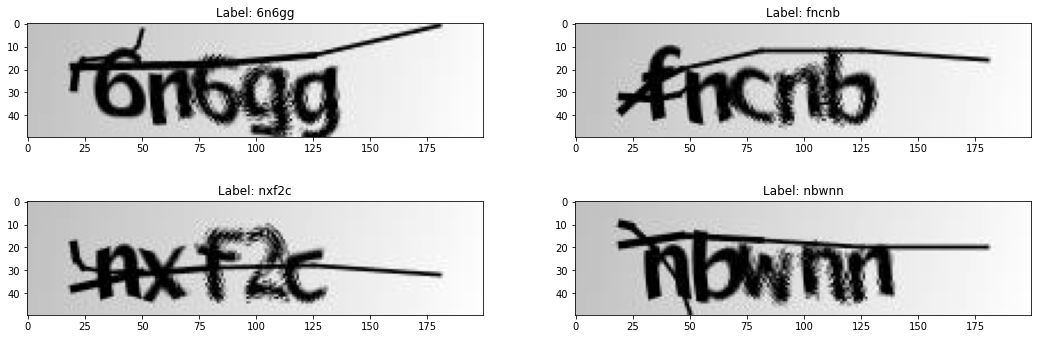

In [5]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 6))
plt.gray()

ax1.set_title(f'Label: {decode_label(y[0])}')
g = ax1.imshow(x[0][:, :, 0])
ax2.set_title(f'Label: {decode_label(y[1])}')
g = ax2.imshow(x[1][:, :, 0])
ax3.set_title(f'Label: {decode_label(y[2])}')
g = ax3.imshow(x[2][:, :, 0])
ax4.set_title(f'Label: {decode_label(y[3])}')
g = ax4.imshow(x[3][:, :, 0])

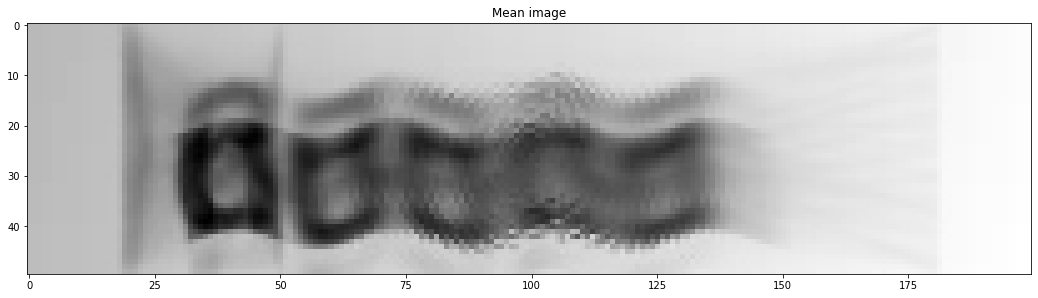

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

ax.set_title('Mean image')
g = ax.imshow(np.average(x, 0)[:, :, 0])

We can see that most the CAPCHAs are contained within a smaller range of pixels than the acutal image size. So we can crop the input images which will lead to fewer parameters and less noise for the model to focus on.

In [7]:
x_crop = x[:, 8:, 20:150, :]

## Train-test split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_crop, y, test_size=0.2)

batch_size=8

dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((x_test, y_test))


# Data Augmentation

This step is made to generate a new set of data samples to train the model on from the given data. Given that we have a limited dataset (~1000 samples) but a high number of labels to predict (5), we need to artificially create more data.

Because letters are not symmetrical, we must only focus on creating more data points by rotating, zooming and shifting the original data.



In [9]:
augment_prob = 0.5
image_shape = x_crop.shape[1:3]  

def random_rotate_image(image):
    image = np.array(image)
    if augment_prob  > np.random.uniform():
        rotation_factor = np.random.uniform(-10, 10)
        image = ndimage.rotate(image, rotation_factor, reshape=False)
    
    return np.reshape(image, image_shape+(1,))

def random_shift_image(image):
    image = np.array(image)
    if augment_prob  > np.random.uniform():
        shift_factor = np.random.uniform(-0.1, 0.1)
        rows, cols = image_shape[:2]

        M = np.float32([[1, 0, cols*shift_factor], [0, 1, rows*shift_factor]])
        dst = cv2.warpAffine(image, M, (cols, rows))
        image = np.reshape(dst, image_shape)
    
    return np.reshape(image, image_shape+(1,))
    
def random_thresholding(image):
    image = np.array(image)[:,:].astype('uint8')
    if augment_prob  > np.random.uniform():
        if 0.5 > np.random.uniform():
            # Adaptive thresholding
            image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 17, 2)
        else:
            # Otsu thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
    return np.reshape(image, image_shape+(1,))
    
def random_zoom(img, **kwargs):
    h, w = img.shape[:2]
    if augment_prob  > np.random.uniform():
        zoom_factor = np.random.uniform(0.7, 1.3)
        zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    
        # Zooming out
        if zoom_factor < 1:

            zh = int(np.round(h * zoom_factor))
            zw = int(np.round(w * zoom_factor))
            top = (h - zh) // 2
            left = (w - zw) // 2

            # Zero-padding
            out = np.zeros_like(img)
            out[top:top+zh, left:left+zw] = ndimage.zoom(img, zoom_tuple, **kwargs)

        # Zooming in
        elif zoom_factor > 1:

            zh = int(np.round(h / zoom_factor))
            zw = int(np.round(w / zoom_factor))
            top = (h - zh) // 2
            left = (w - zw) // 2

            out = ndimage.zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

            # Cropping
            trim_top = ((out.shape[0] - h) // 2)
            trim_left = ((out.shape[1] - w) // 2)
            out = out[trim_top:trim_top+h, trim_left:trim_left+w]

        else:
            out = img
    else:
        out = img
        
    try:
        out = np.reshape(out, image_shape+(1,))
        return out
    except:
        return img
    
def random_noise(image):
    image = np.array(image)[:,:].astype('uint8')
    if augment_prob  > np.random.uniform():
        if 0.5 > np.random.uniform():
            # Gaussian Blur
            img = cv2.GaussianBlur(image, (5, 5), 0)
        else:
            # Salt $ Pepper
            row, col = image_shape
            salt_vs_pepper = 0.5
            pixel_change = 0.05
            img = np.copy(image)
            # Salt
            pixel_salted = np.ceil(pixel_change * image.size * salt_vs_pepper)
            x_coords = np.random.randint(0, col - 1, int(pixel_salted))
            y_coords = np.random.randint(0, row - 1, int(pixel_salted))
            img[y_coords, x_coords] = 255
            # Pepper
            pixel_peppered = np.ceil(pixel_change * image.size * (1-salt_vs_pepper))
            x_coords = np.random.randint(0, col - 1, int(pixel_peppered))
            y_coords = np.random.randint(0, row - 1, int(pixel_peppered))
            img[y_coords, x_coords] = 0
        image = np.reshape(img, image_shape+(1,))
    
    return image
    
def tf_augment_image(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(random_rotate_image, [image], [tf.float64])
    [image,] = tf.py_function(random_shift_image, [image], [tf.float64])
    [image,] = tf.py_function(random_zoom, [image], [tf.float64])
    [image,] = tf.py_function(random_thresholding, [image], [tf.float64])
    [image,] = tf.py_function(random_noise, [image], [tf.float64])
    image /= 255.
    image.set_shape(im_shape)
    
    return image, label

def tf_normalize_image(image, label):
    image /= 255.
    
    return image, label

dataset_train_aug = dataset_train.map(tf_augment_image)
dataset_val_aug = dataset_val.map(tf_normalize_image)

dataset_train_aug = dataset_train_aug.shuffle(buffer_size=1024).batch(batch_size)
dataset_val_aug = dataset_val_aug.shuffle(buffer_size=1024).batch(batch_size)

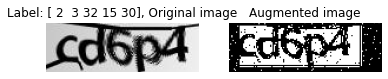

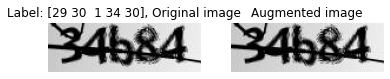

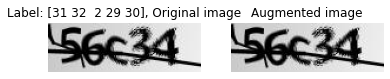

In [10]:
def show(image, augmented_img, label):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.axis('off'), ax2.axis('off')

    g = ax1.imshow(image)
    ax1.set_title(f'Label: {np.argmax(label.numpy(), 1)}, Original image')
    g = ax2.imshow(augmented_img)
    ax2.set_title(f'Augmented image')
    
for image, label in dataset_train.take(3):
    augmented_img = image[:, :, 0]
    augmented_img = random_rotate_image(augmented_img)
    augmented_img = random_shift_image(augmented_img)
    augmented_img = random_zoom(augmented_img)
    augmented_img = random_thresholding(augmented_img)
    augmented_img = random_noise(augmented_img)
    show(image, augmented_img, label)

# Model Design

Here we create the model with shallow linear layers and the last deep layers: a stack of 5 non-sequential layers. 

In [11]:
def model(input_shape, output_shape):
    
    x = Input(shape=input_shape)
    hidden = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    hidden = Conv2D(32, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = MaxPool2D((2, 2))(hidden)

    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(64, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = Conv2D(64, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = MaxPool2D((2, 2))(hidden)

    hidden = BatchNormalization()(hidden)
    hidden = Flatten()(hidden)
    
    # Make 5 branches from it, each responsible of predicting one letter
    outs = []
    for _ in range(5):
        branch = Dense(128, activation='relu')(hidden)
        drop = Dropout(0.2)(branch)
        res = Dense(len(symbols), activation='softmax')(drop)
        outs.append(res)
    return Model(inputs=x, outputs=outs)

model = model((x_crop.shape[1], x_crop.shape[2], 1), len(symbols))

In [12]:
class LetterAccuracy(tf.keras.metrics.Metric):
    ''' Custom metric for the model's branch accuracy '''
    def __init__(self, name='one_off_accuracy', idx=0, **kwargs):
        super(LetterAccuracy, self).__init__(name=name, **kwargs)
        self.la = self.add_weight(name="ctp", initializer="zeros")
        self.idx = idx

    def update_state(self, y_gt, y_preds):
        y_true = y_gt[self.idx]
        y_pred = y_preds[self.idx]
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        y_true = tf.reshape(tf.argmax(y_true, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        self.la.assign_add(tf.reduce_sum(values))
        
    def result(self):
        return self.la

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.la.assign(0.0)

In [13]:
class PartialAccuracy(tf.keras.metrics.Metric):
    ''' Custom metric for partial accuracy or total accuracy '''
    def __init__(self, name='one_off_accuracy', threshold=4, **kwargs):
        super(PartialAccuracy, self).__init__(name=name, **kwargs)
        self.acc = self.add_weight(name="ctp", initializer="zeros")
        self.threshold = threshold
        
    def update_state(self, y_gt, y_preds):
        # Split the model's branch outputs/labels
        y_pred_0 = tf.reshape(tf.argmax(y_preds[0], axis=1), shape=(-1, 1))
        y_true_0 = tf.reshape(tf.argmax(y_gt[0], axis=1), shape=(-1, 1))
        y_pred_1 = tf.reshape(tf.argmax(y_preds[1], axis=1), shape=(-1, 1))
        y_true_1 = tf.reshape(tf.argmax(y_gt[1], axis=1), shape=(-1, 1))
        y_pred_2 = tf.reshape(tf.argmax(y_preds[2], axis=1), shape=(-1, 1))
        y_true_2 = tf.reshape(tf.argmax(y_gt[2], axis=1), shape=(-1, 1))
        y_pred_3 = tf.reshape(tf.argmax(y_preds[3], axis=1), shape=(-1, 1))
        y_true_3 = tf.reshape(tf.argmax(y_gt[3], axis=1), shape=(-1, 1))
        y_pred_4 = tf.reshape(tf.argmax(y_preds[4], axis=1), shape=(-1, 1))
        y_true_4 = tf.reshape(tf.argmax(y_gt[4], axis=1), shape=(-1, 1))
        # Compute the number of correct predictions
        values = (
            tf.cast((tf.cast(y_true_0, "int32") == tf.cast(y_pred_0, "int32")), "float32") + 
            tf.cast((tf.cast(y_true_1, "int32") == tf.cast(y_pred_1, "int32")), "float32") +
            tf.cast((tf.cast(y_true_2, "int32") == tf.cast(y_pred_2, "int32")), "float32") + 
            tf.cast((tf.cast(y_true_3, "int32") == tf.cast(y_pred_3, "int32")), "float32") + 
            tf.cast((tf.cast(y_true_4, "int32") == tf.cast(y_pred_4, "int32")), "float32")) 
        values = tf.cast(values, "float32")
        # Compute the number of values with at most one letter mistaken.
        precision = values >= self.threshold
        precision = tf.cast(precision, "float32")
        self.acc.assign_add(tf.reduce_mean(precision))
        
    def result(self):
        return self.acc

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.acc.assign(0.0)

In [14]:
class CustomModel(tf.keras.Model):
    def __init__(self, model, **kwargs):
        super(CustomModel, self).__init__(**kwargs)

        self.model = model

        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()

        self.acc = tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        self.loss_metric = tf.keras.metrics.Mean(name='loss')
        self.la_0 = tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        self.la_1 = tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        self.la_2 = tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        self.la_3 = tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        self.la_4 = tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        self.t3a_0 = tf.keras.metrics.TopKCategoricalAccuracy(k=3)
        self.t3a_1 = tf.keras.metrics.TopKCategoricalAccuracy(k=3)
        self.t3a_2 = tf.keras.metrics.TopKCategoricalAccuracy(k=3)
        self.t3a_3 = tf.keras.metrics.TopKCategoricalAccuracy(k=3)
        self.t3a_4 = tf.keras.metrics.TopKCategoricalAccuracy(k=3)
        self.pa = PartialAccuracy(threshold=4)
        self.perfection = PartialAccuracy(threshold=5)

    @property
    def metrics(self):
        return [
            self.acc,
            self.loss_metric,
            self.la_0,
            self.la_1,
            self.la_2,
            self.la_3,
            self.la_4,
            self.t3a_0,
            self.t3a_1,
            self.t3a_2,
            self.t3a_3,
            self.t3a_4,
            self.pa,
            self.perfection
        ]

    @tf.function
    def test_step(self, data):
        x, y_raw = data
        y = [y_raw[:, 0], y_raw[:, 1], y_raw[:, 2], y_raw[:, 3], y_raw[:, 4]]
        
        # Inference on test set
        y_pred = self.model(x, training=False)
        
        # Update metrics
        self.acc.update_state(y, y_pred)
        self.la_0.update_state(y_raw[:, 0], y_pred[0])
        self.la_1.update_state(y_raw[:, 1], y_pred[1])
        self.la_2.update_state(y_raw[:, 2], y_pred[2])
        self.la_3.update_state(y_raw[:, 3], y_pred[3])
        self.la_4.update_state(y_raw[:, 4], y_pred[4])
        self.t3a_0.update_state(y_raw[:, 0], y_pred[0])
        self.t3a_1.update_state(y_raw[:, 1], y_pred[1])
        self.t3a_2.update_state(y_raw[:, 2], y_pred[2])
        self.t3a_3.update_state(y_raw[:, 3], y_pred[3])
        self.t3a_4.update_state(y_raw[:, 4], y_pred[4])
        self.pa.update_state(y, y_pred)
        self.perfection.update_state(y, y_pred)

        return {
            "Aggregate-Accuracy": self.acc.result(),
            "Letter-1-Accuracy": self.la_0.result(),
            "Letter-2-Accuracy": self.la_1.result(),
            "Letter-3-Accuracy": self.la_2.result(),
            "Letter-4-Accuracy": self.la_3.result(),
            "Letter-5-Accuracy": self.la_4.result(),
            "Top3-Letter-1": self.t3a_0.result(),
            "Top3-Letter-2": self.t3a_1.result(),
            "Top3-Letter-3": self.t3a_2.result(),
            "Top3-Letter-4": self.t3a_3.result(),
            "Top3-Letter-5": self.t3a_4.result(),
            "Partial-Accuracy": self.pa.result(),
            "Exact-Accuracy": self.perfection.result(),
        }

    @tf.function
    def train_step(self, data):
        x_batch, y_raw = data
        y_batch = [y_raw[:, 0], y_raw[:, 1], y_raw[:, 2], y_raw[:, 3], y_raw[:, 4]]
        
        # Forward pass
        with tf.GradientTape() as tape:
            y_pred = self.model(x_batch, training=True)
            total_loss = self.loss_fn(y_batch, y_pred)

        # Backpropagation
        grads = tape.gradient(total_loss, self.model.trainable_weights)

        # Weigth update
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        
        # Update training metric
        self.acc.update_state(y_batch, y_pred)
        self.loss_metric.update_state(total_loss)
        self.la_0.update_state(y_raw[:, 0], y_pred[0])
        self.la_1.update_state(y_raw[:, 1], y_pred[1])
        self.la_2.update_state(y_raw[:, 2], y_pred[2])
        self.la_3.update_state(y_raw[:, 3], y_pred[3])
        self.la_4.update_state(y_raw[:, 4], y_pred[ 4])
        self.t3a_0.update_state(y_raw[:, 0], y_pred[0])
        self.t3a_1.update_state(y_raw[:, 1], y_pred[1])
        self.t3a_2.update_state(y_raw[:, 2], y_pred[2])
        self.t3a_3.update_state(y_raw[:, 3], y_pred[3])
        self.t3a_4.update_state(y_raw[:, 4], y_pred[4])
        self.pa.update_state(y_batch, y_pred)
        self.perfection.update_state(y_batch, y_pred)
        
        # Display
        return {
            "Aggregate-Accuracy": self.acc.result(),
            "Categorical Cross Entropy": self.loss_metric.result(),
            "Letter-1-Accuracy": self.la_0.result(),
            "Letter-2-Accuracy": self.la_1.result(),
            "Letter-3-Accuracy": self.la_2.result(),
            "Letter-4-Accuracy": self.la_3.result(),
            "Letter-5-Accuracy": self.la_4.result(),
            "Top3-Letter-1": self.t3a_0.result(),
            "Top3-Letter-2": self.t3a_1.result(),
            "Top3-Letter-3": self.t3a_2.result(),
            "Top3-Letter-4": self.t3a_3.result(),
            "Top3-Letter-5": self.t3a_4.result(),
            "Partial-Accuracy": self.pa.result(),
            "Exact-Accuracy": self.perfection.result()
        }

In [15]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

cm = CustomModel(model)
cm.compile(optimizer)
_ = cm.evaluate(dataset_val_aug)

27/27 [==============================] - 2s 24ms/step - Aggregate-Accuracy: 0.0352 - Letter-1-Accuracy: 0.0327 - Letter-2-Accuracy: 0.0226 - Letter-3-Accuracy: 0.0000e+00 - Letter-4-Accuracy: 0.1191 - Letter-5-Accuracy: 0.0017 - Top3-Letter-1: 0.0668 - Top3-Letter-2: 0.0475 - Top3-Letter-3: 0.0674 - Top3-Letter-4: 0.1602 - Top3-Letter-5: 0.0424 - Partial-Accuracy: 0.0000e+00 - Exact-Accuracy: 0.0000e+00


# Training 

In [16]:
history = cm.fit(dataset_train_aug, epochs=30, validation_data=dataset_val_aug)

Epoch 1/30
107/107 [==============================] - 20s 135ms/step - Aggregate-Accuracy: 0.0940 - Categorical Cross Entropy: 4.3087 - Letter-1-Accuracy: 0.0839 - Letter-2-Accuracy: 0.1051 - Letter-3-Accuracy: 0.1183 - Letter-4-Accuracy: 0.0860 - Letter-5-Accuracy: 0.0769 - Top3-Letter-1: 0.2107 - Top3-Letter-2: 0.2519 - Top3-Letter-3: 0.2745 - Top3-Letter-4: 0.2064 - Top3-Letter-5: 0.1689 - Partial-Accuracy: 0.0995 - Exact-Accuracy: 0.0000e+00 - val_Aggregate-Accuracy: 0.0698 - val_Letter-1-Accuracy: 0.0465 - val_Letter-2-Accuracy: 0.1070 - val_Letter-3-Accuracy: 0.0465 - val_Letter-4-Accuracy: 0.0837 - val_Letter-5-Accuracy: 0.0651 - val_Top3-Letter-1: 0.2512 - val_Top3-Letter-2: 0.2930 - val_Top3-Letter-3: 0.2326 - val_Top3-Letter-4: 0.1535 - val_Top3-Letter-5: 0.1767 - val_Partial-Accuracy: 0.0000e+00 - val_Exact-Accuracy: 0.0000e+00
Epoch 2/30
107/107 [==============================] - 18s 135ms/step - Aggregate-Accuracy: 0.2403 - Categorical Cross Entropy: 2.5886 - Letter-1-Accu

Let's explore the outputs of some of the convolutional layers to determine if they are analysing noise or picking up on an actual signal.    

In [17]:
def get_layer_output(model, idx, sample):
    assert idx < len(model.layers)
    assert idx > -2

    try:
        data_flow = K.function([model.layers[0].input],
                            [model.layers[idx].output])
        return data_flow(sample)
    except:
        print("Cannot get the layer")
        return None

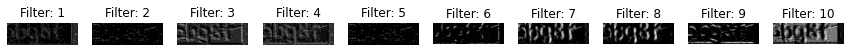

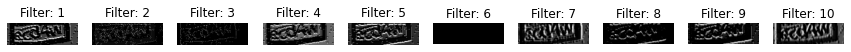

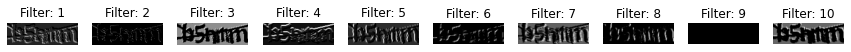

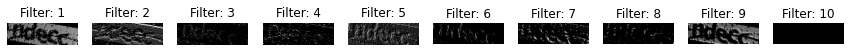

In [18]:
def show_vfeats(image1, image2, image3, image4, image5, image6, image7, image8, image9, image10):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(1, 10, figsize=(15,15))
    ax1.axis('off'), ax2.axis('off'), ax3.axis('off'), ax4.axis('off'), ax5.axis('off'),
    ax6.axis('off'), ax7.axis('off'), ax8.axis('off'), ax9.axis('off'), ax10.axis('off')

    g = ax1.imshow(image1)
    ax1.set_title(f'Filter: {1}')
    g = ax2.imshow(image2)
    ax2.set_title(f'Filter: {2}')
    g = ax3.imshow(image3)
    ax3.set_title(f'Filter: {3}')
    g = ax4.imshow(image4)
    ax4.set_title(f'Filter: {4}')
    g = ax5.imshow(image5)
    ax5.set_title(f'Filter: {5}')
    g = ax6.imshow(image6)
    ax6.set_title(f'Filter: {6}')
    g = ax7.imshow(image7)
    ax7.set_title(f'Filter: {7}')
    g = ax8.imshow(image8)
    ax8.set_title(f'Filter: {8}')
    g = ax9.imshow(image9)
    ax9.set_title(f'Filter: {9}')
    g = ax10.imshow(image10)
    ax10.set_title(f'Filter: {10}')

for image, label in dataset_train_aug.take(4):
    vfeat_1 = get_layer_output(model, 1, np.array([image[0]]))[0]
    vfeat_2 = get_layer_output(model, 2, np.array([image[0]]))[0]

    show_vfeats(
        np.reshape(vfeat_1[0, :, :, np.random.randint(0, 32)], (40, 128)),
        np.reshape(vfeat_1[0, :, :, np.random.randint(0, 32)], (40, 128)),
        np.reshape(vfeat_1[0, :, :, np.random.randint(0, 32)], (40, 128)),
        np.reshape(vfeat_1[0, :, :, np.random.randint(0, 32)], (40, 128)),
        np.reshape(vfeat_1[0, :, :, np.random.randint(0, 32)], (40, 128)),
        np.reshape(vfeat_2[0, :, :, np.random.randint(0, 32)], (38, 126)),
        np.reshape(vfeat_2[0, :, :, np.random.randint(0, 32)], (38, 126)),
        np.reshape(vfeat_2[0, :, :, np.random.randint(0, 32)], (38, 126)),
        np.reshape(vfeat_2[0, :, :, np.random.randint(0, 32)], (38, 126)),
        np.reshape(vfeat_2[0, :, :, np.random.randint(0, 32)], (38, 126))
        )

Let's vizualise some of the model's prediction.

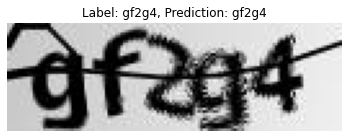

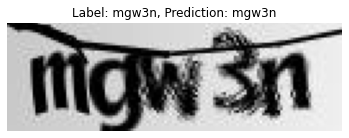

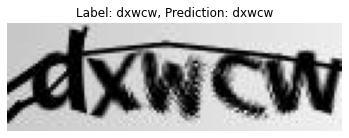

In [19]:
for image, label in dataset_val_aug.take(3):
    fig, ax1 = plt.subplots(1, 1)
    ax1.axis('off')
    g = ax1.imshow(image[0])
    ax1.set_title(f'Label: {decode_label(label[0])}, Prediction: {decode_label(model.predict(np.array([image[0]])))}')